Стан Илья Андреевич, 8 в списке, вариант 9

Город в Китае - Hong Kong

Страна - Belgium

# Требования к отчету 

Задание оформляется в виде ноутбука на языке Python и сдается в гугл классрум. 

Номер варианта соответствует номеру в журнале соответствующей группы.
У 11 номера в журнале - 1 вариант, у 12 - второй и так далее.

Срок выполнения задания 2 недели до следующей лекции.

Все выводы должны быть строго статистически обоснованы результатами вычислений и соответствующими текстовыми комментариями.

Каждый выбирает себе одну страну и один город в Китае.

Номер варианта равен 1 + остаток от деления номера в списке группы на 10 


## Вариант 9
Сравниваем волны коронавируса.

* Построить аддитивную оценку сезонной компоненты для процесса ежедневной смертности для данных с 1 января по 30 августа 2022 года и с 1 сентября 2022 по 31 декабря 2022. 

(Выбор лучшего периода для сезонности, 4 графика)

* Построить графики недельной сезонной компоненты с привязкой ко дням недели

(4 графика, см подход в tsa1)

* В какой день недели смертность максимальна и минимальна в период первой и второй волны пандемии?

(Оценить в среднем по сезонной компоненте)

* Оценить показатель Херста к ряду для лагов 7,30,60,90 дней. Персистентный или антиперсистентный ряд.

* Проверить остатки после удаления сезонных компонент на стационарность. Выдать `P-value` соответствующего критерия и вывод о стационарности каждого ряда остатков. 

* Построить автокорреляционную функцию для остатков.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm

In [2]:
df = pd.read_csv("time_series_covid19_deaths_global.csv")
df["Province/State"] = df["Province/State"].fillna(value="")

In [3]:
df.head(1)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,2/28/23,3/1/23,3/2/23,3/3/23,3/4/23,3/5/23,3/6/23,3/7/23,3/8/23,3/9/23
0,,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,7896,7896,7896,7896,7896,7896,7896,7896,7896,7896


In [4]:
# Города в Китае и Страны
df.where(df["Country/Region"] == "China")["Province/State"].unique(), df["Country/Region"].unique()[15:20]

(array([nan, 'Anhui', 'Beijing', 'Chongqing', 'Fujian', 'Gansu',
        'Guangdong', 'Guangxi', 'Guizhou', 'Hainan', 'Hebei',
        'Heilongjiang', 'Henan', 'Hong Kong', 'Hubei', 'Hunan',
        'Inner Mongolia', 'Jiangsu', 'Jiangxi', 'Jilin', 'Liaoning',
        'Macau', 'Ningxia', 'Qinghai', 'Shaanxi', 'Shandong', 'Shanghai',
        'Shanxi', 'Sichuan', 'Tianjin', 'Tibet', 'Unknown', 'Xinjiang',
        'Yunnan', 'Zhejiang'], dtype=object),
 array(['Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin'], dtype=object))

In [5]:
belgium = df.where(df["Country/Region"] == "Belgium").dropna(axis=0).iloc[0]
hongkong = df.where(df["Province/State"] == "Hong Kong").dropna(axis=0).iloc[0]

In [6]:
belgium

Province/State            
Country/Region     Belgium
Lat                50.8333
Long              4.469936
1/22/20                0.0
                    ...   
3/5/23             33775.0
3/6/23             33775.0
3/7/23             33775.0
3/8/23             33775.0
3/9/23             33814.0
Name: 24, Length: 1147, dtype: object

In [7]:
hongkong

Province/State    Hong Kong
Country/Region        China
Lat                    22.3
Long                  114.2
1/22/20                 0.0
                    ...    
3/5/23              13465.0
3/6/23              13466.0
3/7/23              13466.0
3/8/23              13466.0
3/9/23              13467.0
Name: 71, Length: 1147, dtype: object

In [8]:
names = ("Belgium first wave", "Belgium second wave", "Hong Kong first wave", "Hong Kong second wave")

b1 = np.array(belgium.iloc[714:956], dtype=int)
b2 = np.array(belgium.iloc[957:1079], dtype=int)
h1 = np.array(hongkong.iloc[714:956], dtype=int)
h2 = np.array(hongkong.iloc[957:1079], dtype=int)

series = [b1, b2, h1, h2]

Номер 1

In [9]:
SMA_LAGS = 3
N_GRAPHS = 4

In [10]:
def get_sma(ts: np.ndarray, n_lags: int, weights: list[int] | None = None) -> np.ndarray:
    '''
    Evaluate a trend with sma methodology.

    Parameters:
    -----------

    ts: ndarray:
        - time series of a process.
    
    n_lags: int:
        - number of additives in mean evaluation.
    
    weights: list[int] | None:
        - weights for sma calculation: $sma = weights_0 / len * ts_t + weights_1 / len * ts_{t-1} + ... + weights_1 / len * ts_{t+1} + ...
        By default weights = 1.
    '''
    if weights is None:
        weights = [1] * n_lags
    cur_idx = n_lags - 1
    sma = weights[0] * ts[cur_idx:-cur_idx] + weights[cur_idx] * ts[2*cur_idx:]

    for lag in range(1, n_lags):
        sma += weights[lag] * ts[cur_idx - lag:-cur_idx - lag]
    for lag in range(1, n_lags - 1):
        sma += weights[lag] * ts[cur_idx + lag:-cur_idx + lag]

    return sma / (2 * sum(weights) - weights[0])


assert np.all((get_sma(np.array([1, 2, 1, 2]), 2) == np.array([4/3, 5/3])))
assert np.all((get_sma(np.array([2, 2, 2, 2, 2, 2, 2, 2]), 4) == np.array([2, 2])))

In [11]:
smas = list(map(lambda x: get_sma(x, SMA_LAGS), series))

In [12]:
series_no_m = list(map(lambda x: series[x][SMA_LAGS - 1:- SMA_LAGS + 1] - smas[x], list(range(N_GRAPHS))))

In [13]:
def get_seasonal(ts_no_m: np.ndarray, seasons: int) -> np.ndarray:
    '''
    Get a seasonal component with a nonparametric method.

    Parameters:
    -----------

    ts_no_m: ndarray:
        - time series of a process with trend being removed.
    
    seasons: int:
        - number of seasons for evaluation.
    '''
    seasonal = np.zeros(seasons)
    for i in range(seasons):
        seasonal[i] = np.mean(ts_no_m[i::seasons])
    return seasonal - np.mean(seasonal)

assert np.all(get_seasonal(np.array([1, 2, 3]), 2) == np.array([0, 0]))
assert np.all(get_seasonal(np.array([1, 2, 3, 4]), 2) == np.array([-0.5, 0.5]))

In [14]:
def get_seasonal_full(ts_no_m: np.ndarray, seasons: int) -> np.ndarray:
    '''
    Get a seasonal component with a nonparametric method.

    Parameters:
    -----------

    ts_no_m: ndarray:
        - time series of a process with trend being removed.
    
    seasons: int:
        - number of seasons for evaluation.
    '''
    seasonal = np.zeros_like(ts_no_m)
    for i in range(seasons):
        seasonal[i::seasons] = np.mean(ts_no_m[i::seasons])
    return seasonal - np.mean(seasonal)

Графики

Belgium first wave decomposition 2 seasons


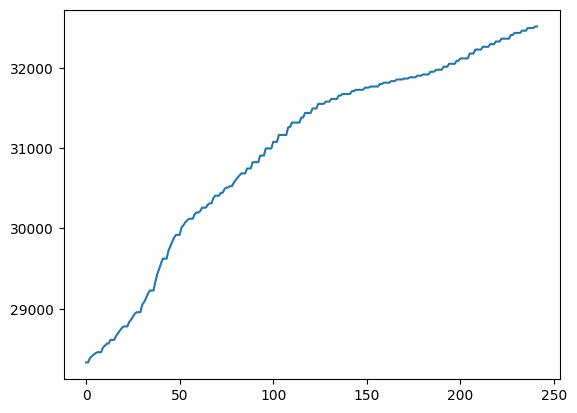

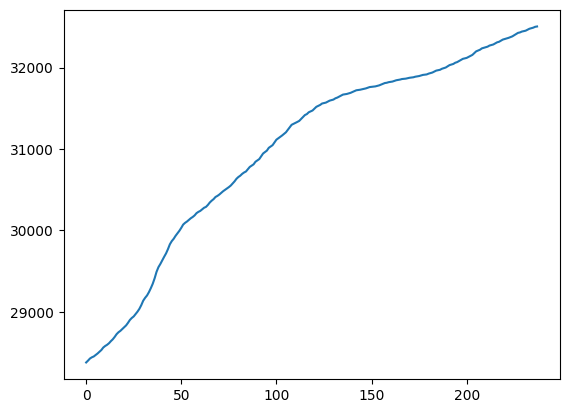

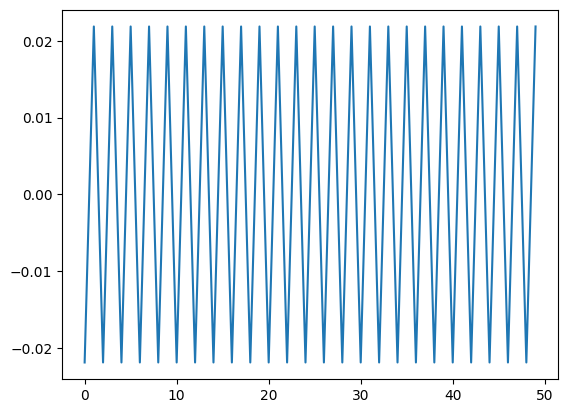

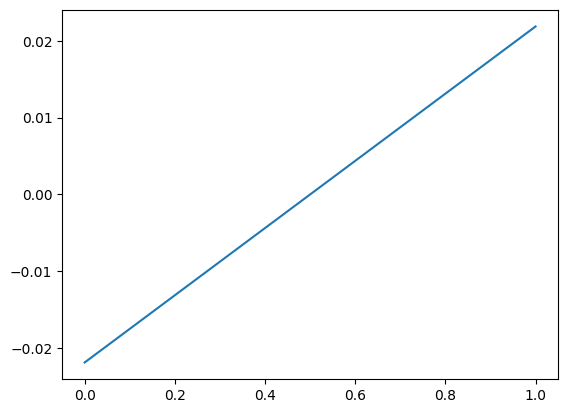

Belgium first wave decomposition 3 seasons


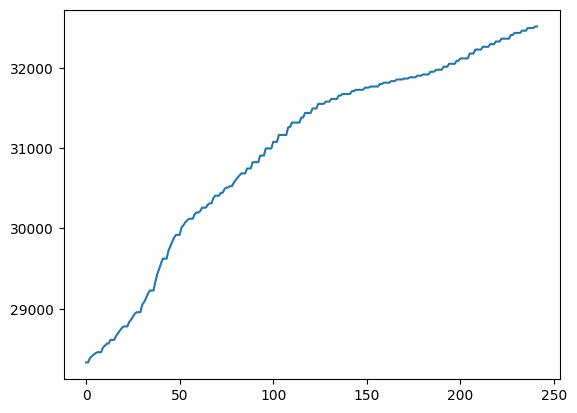

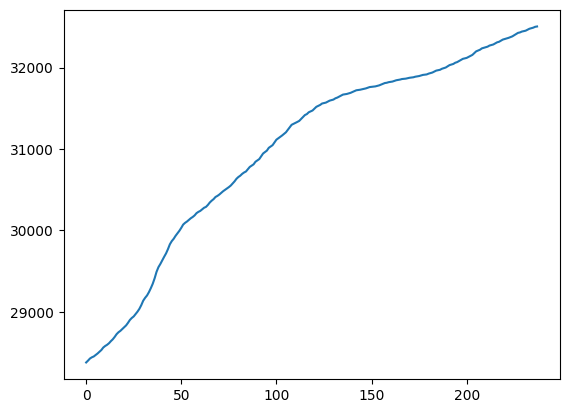

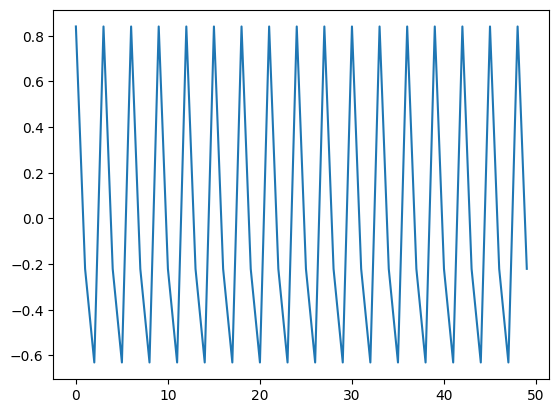

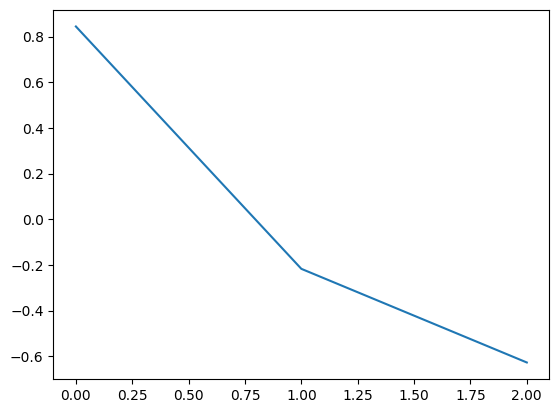

Belgium first wave decomposition 7 seasons


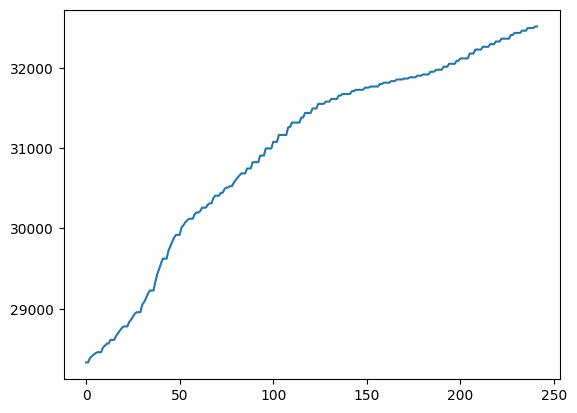

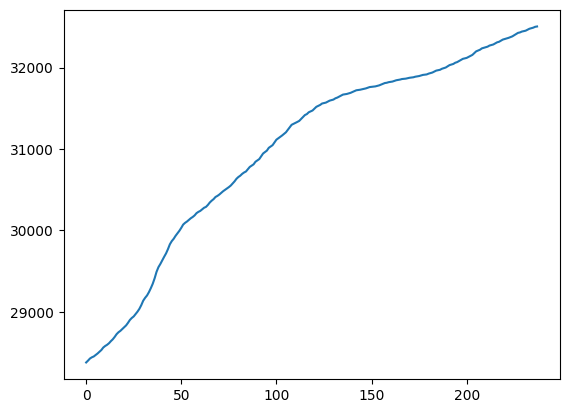

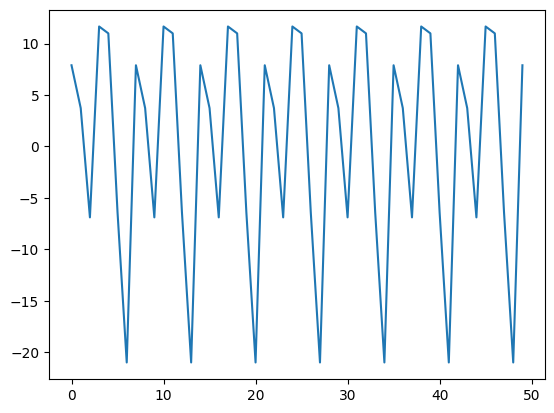

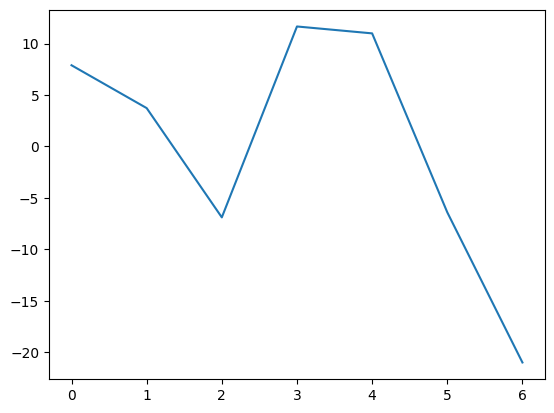

Belgium first wave decomposition 10 seasons


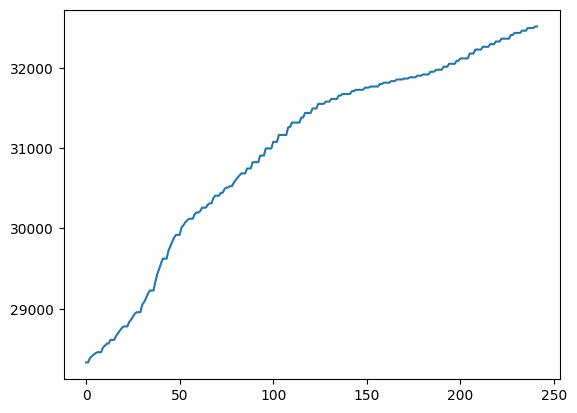

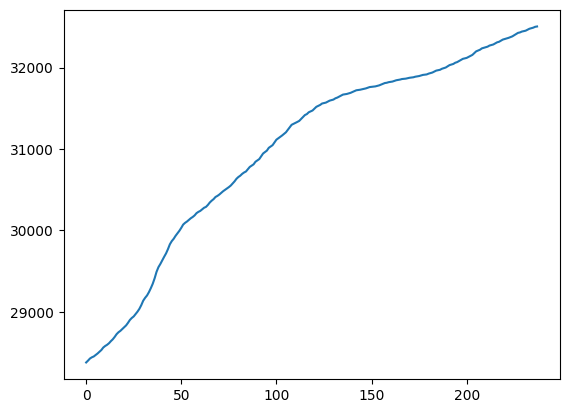

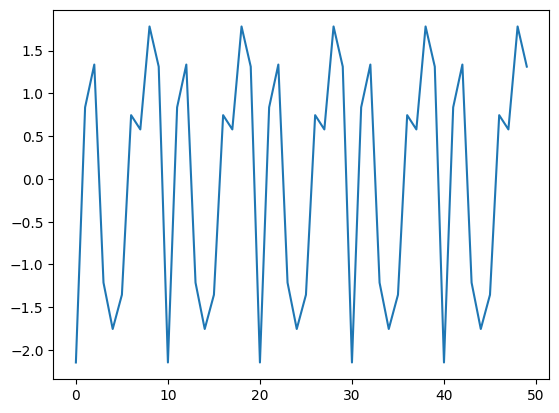

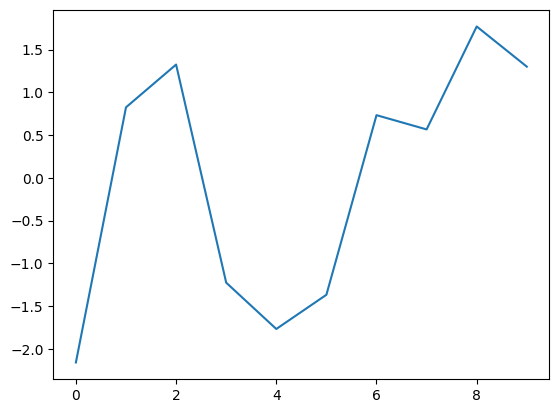

Belgium first wave decomposition 15 seasons


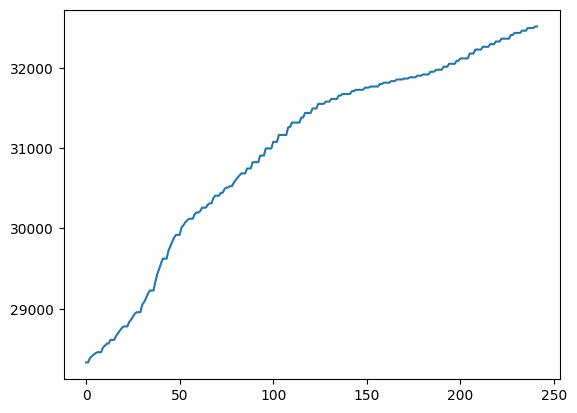

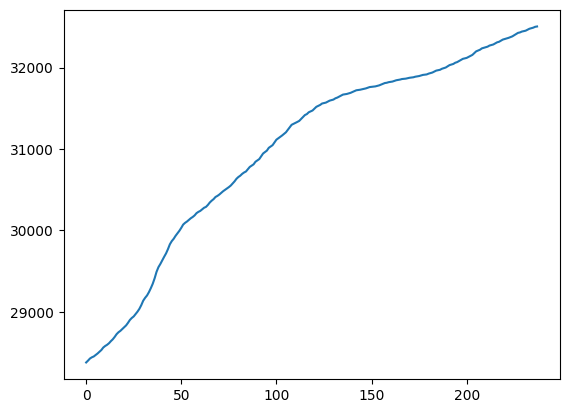

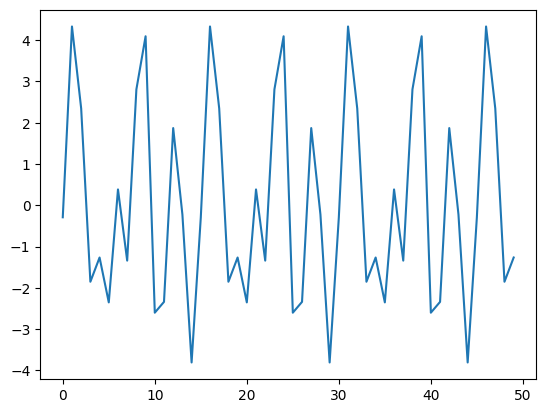

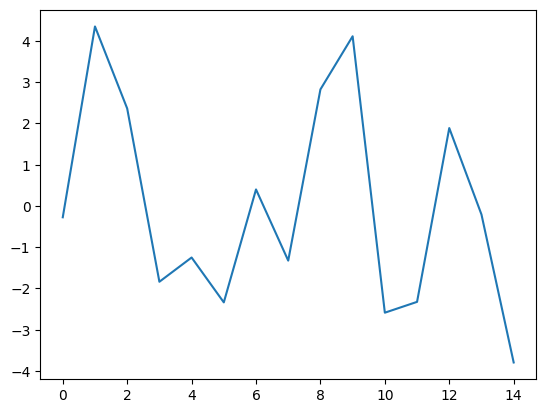

Belgium second wave decomposition 2 seasons


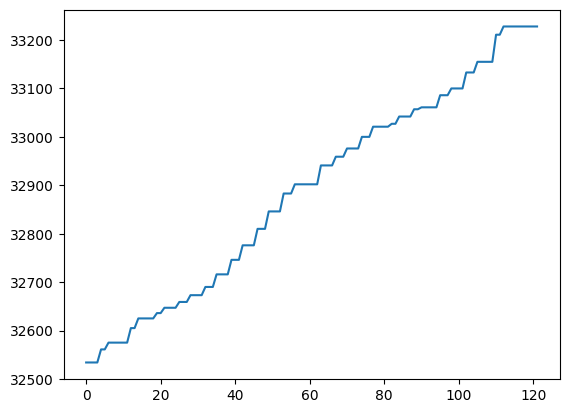

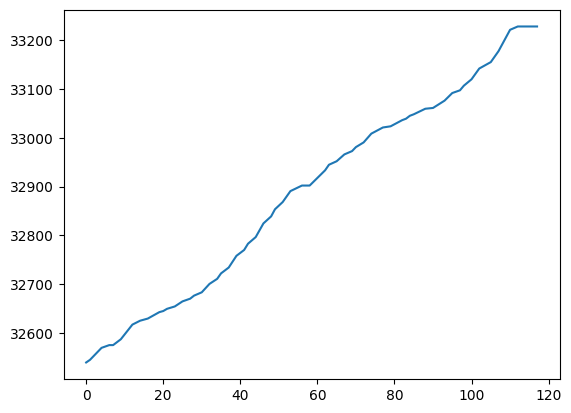

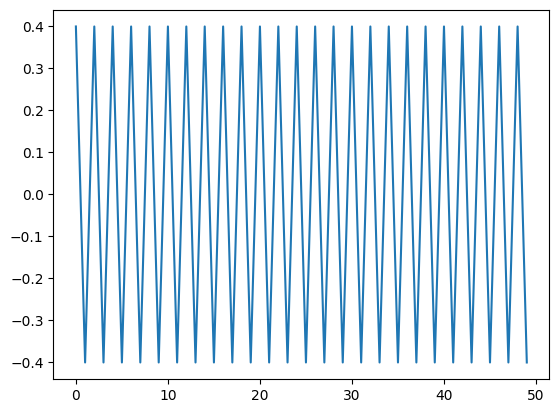

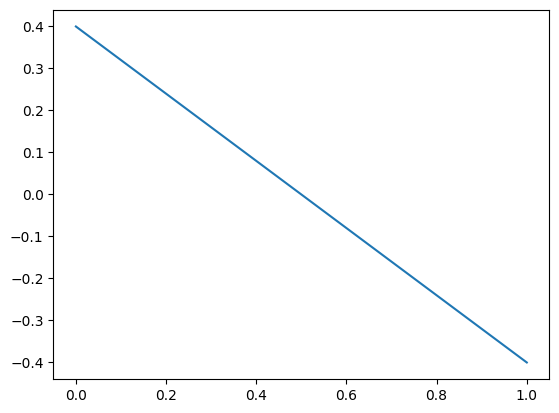

Belgium second wave decomposition 3 seasons


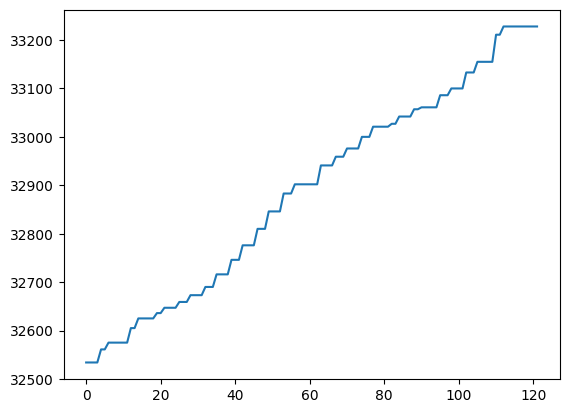

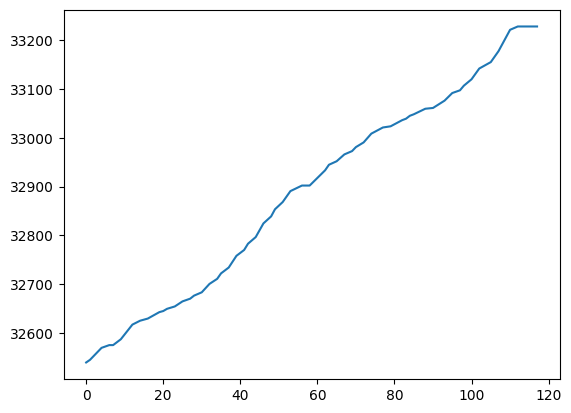

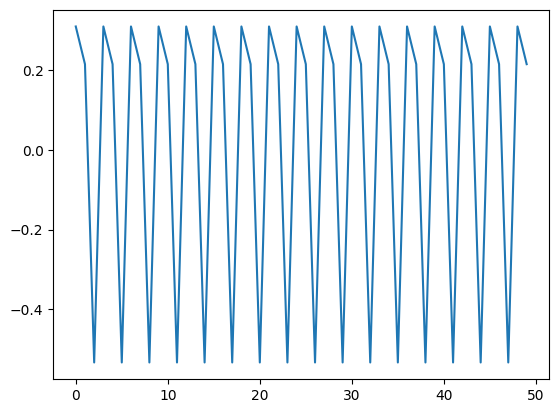

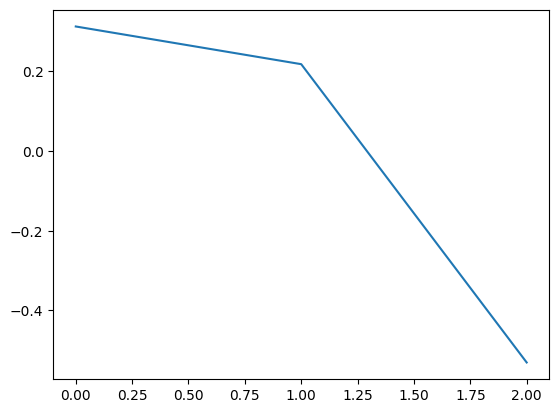

Belgium second wave decomposition 7 seasons


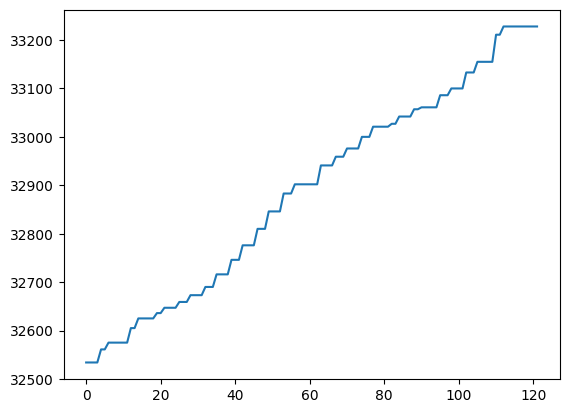

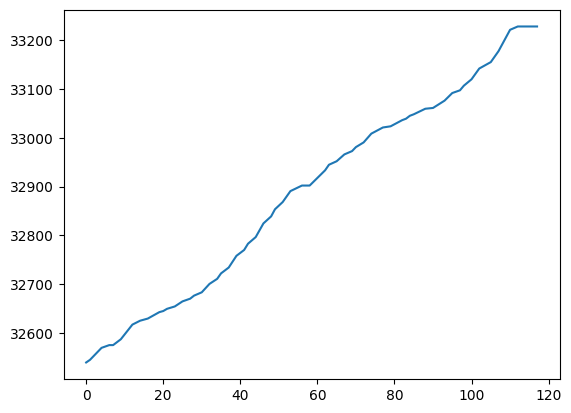

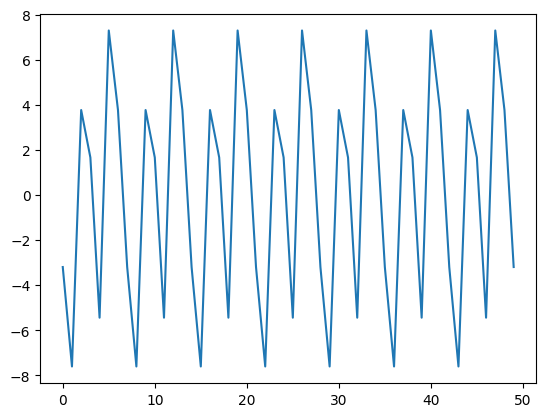

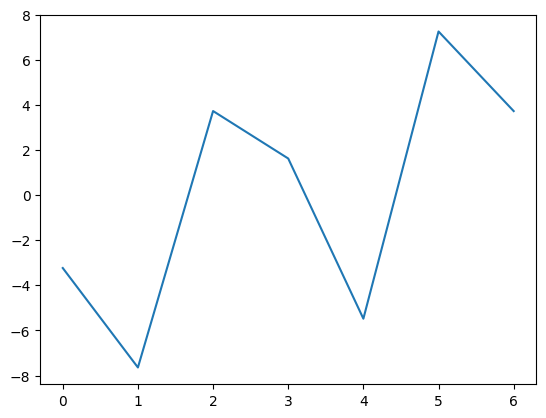

Belgium second wave decomposition 10 seasons


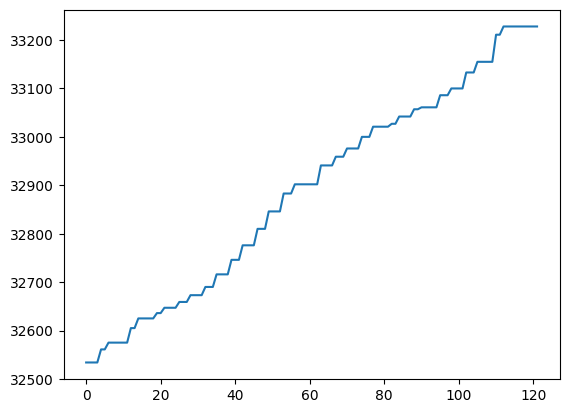

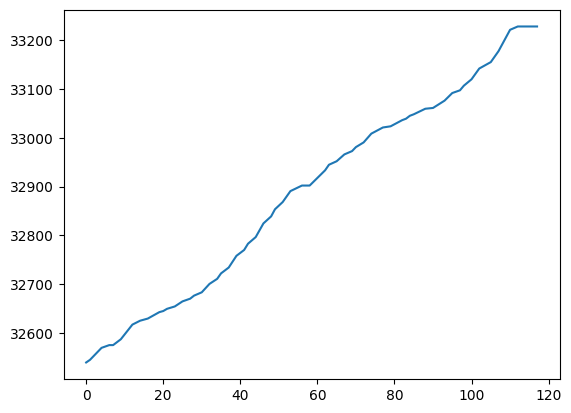

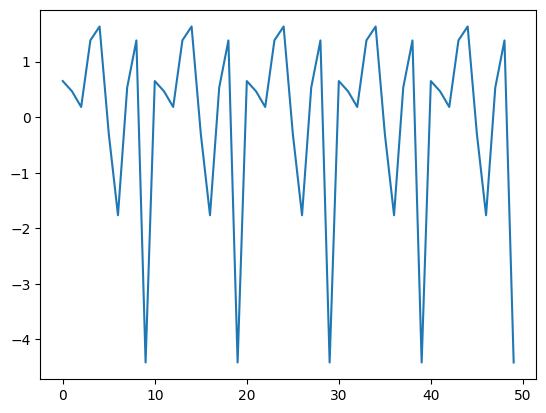

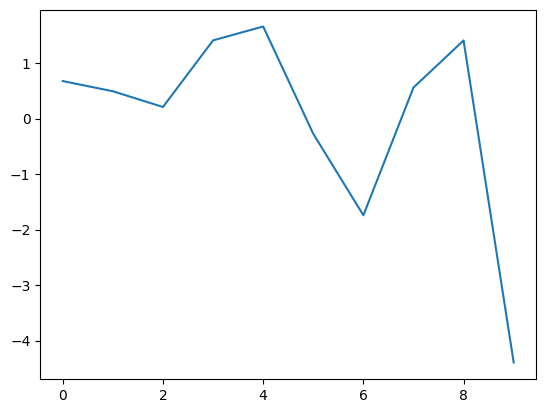

Belgium second wave decomposition 15 seasons


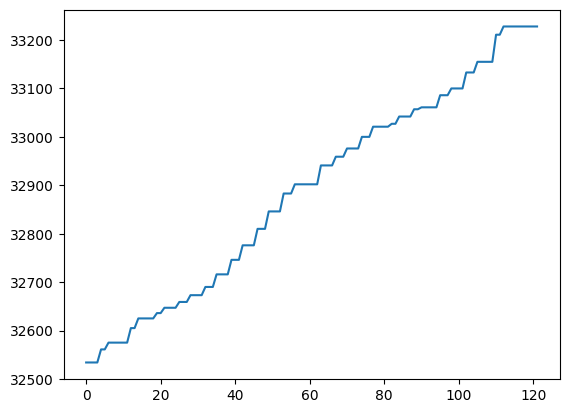

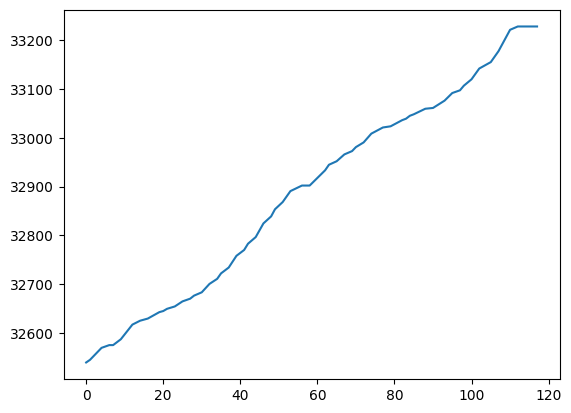

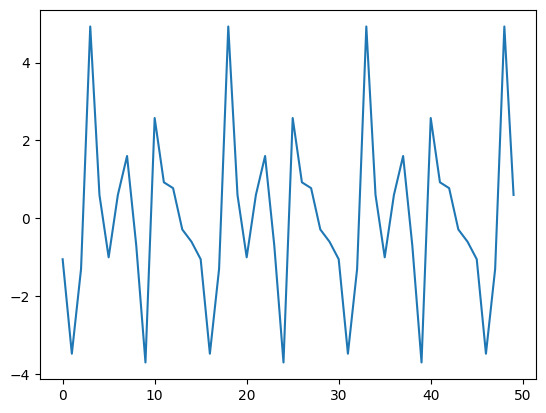

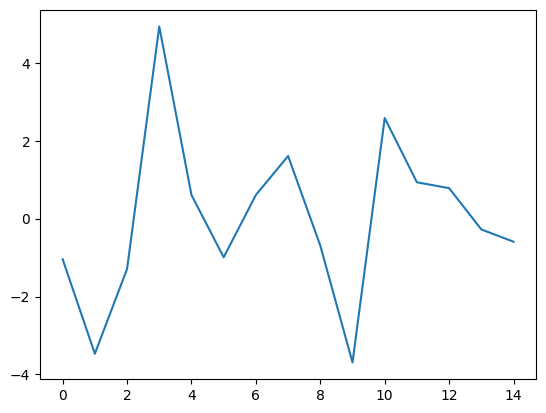

Hong Kong first wave decomposition 2 seasons


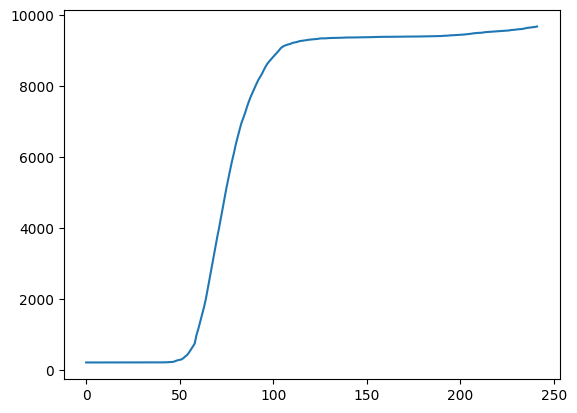

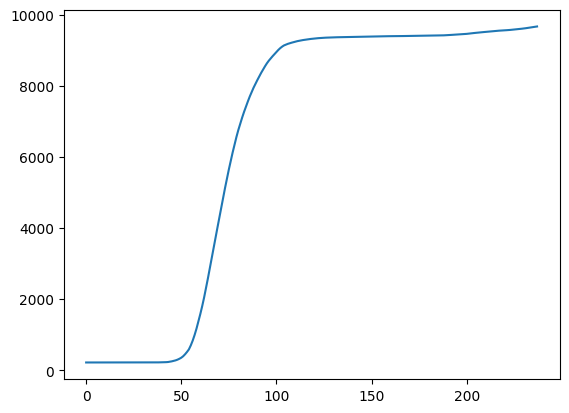

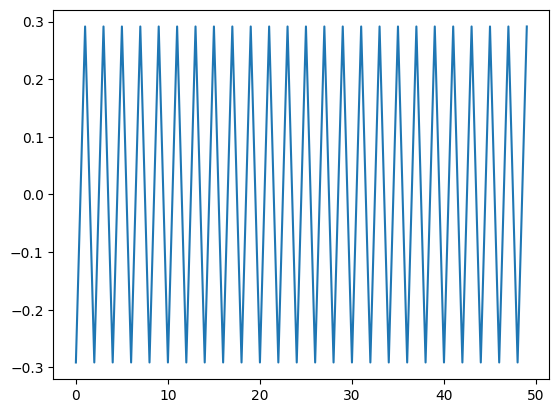

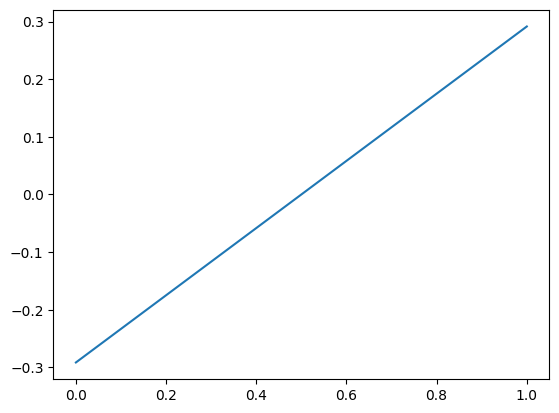

Hong Kong first wave decomposition 3 seasons


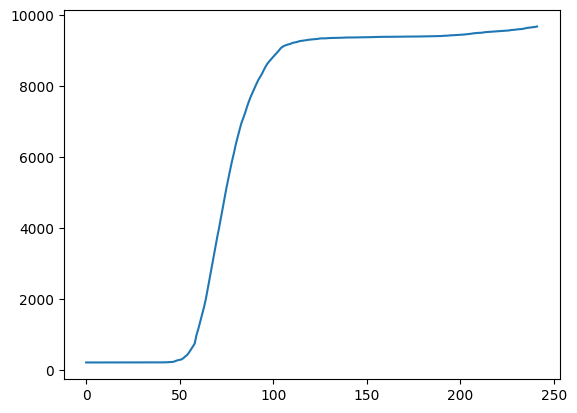

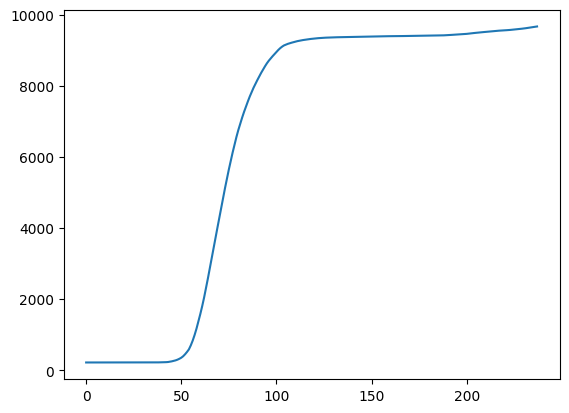

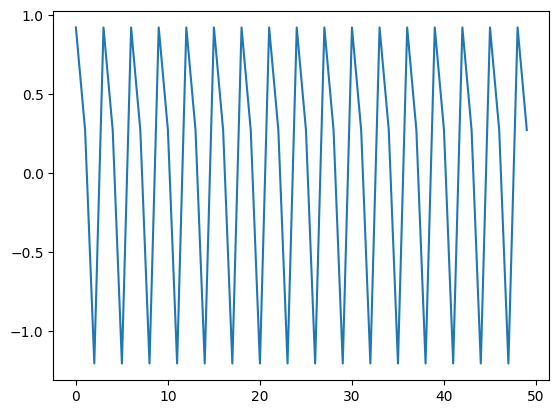

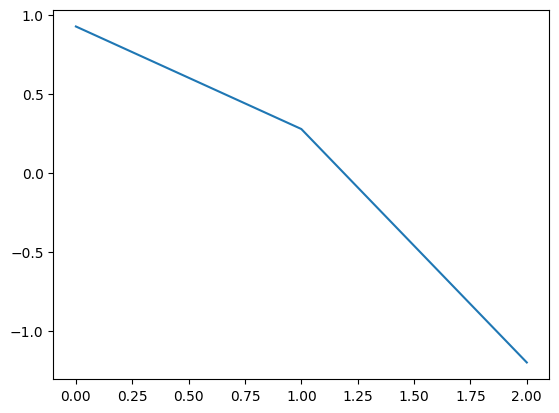

Hong Kong first wave decomposition 7 seasons


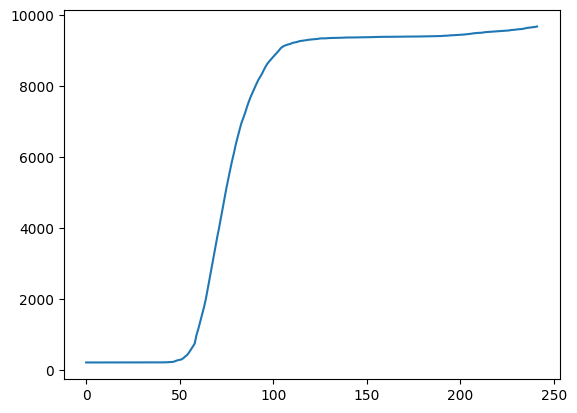

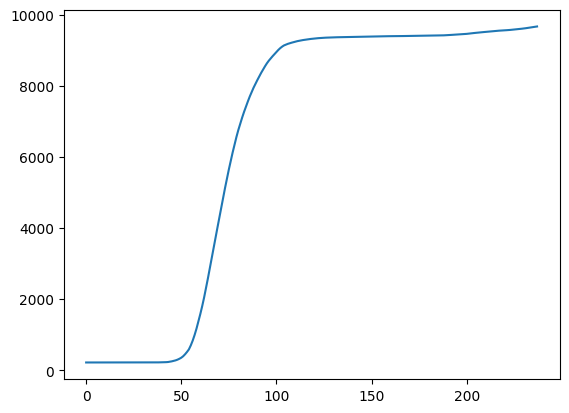

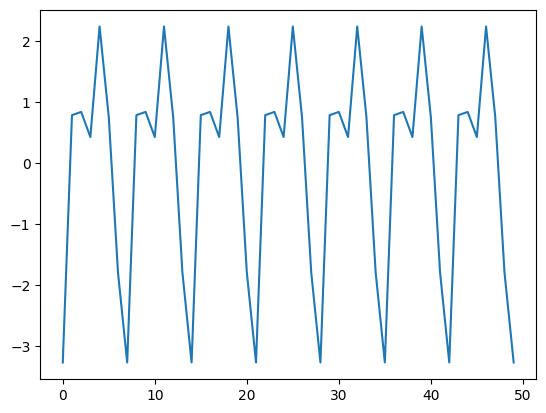

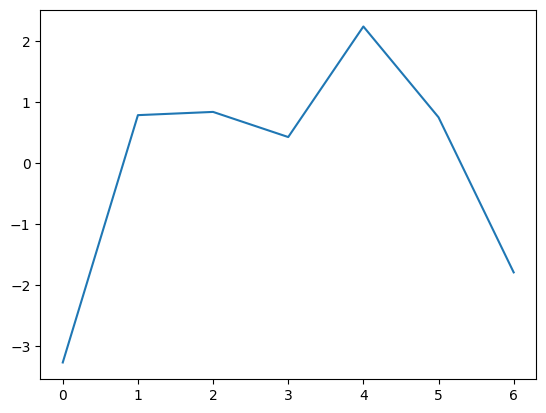

Hong Kong first wave decomposition 10 seasons


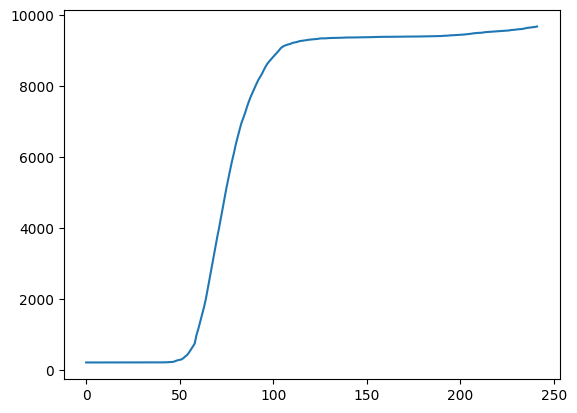

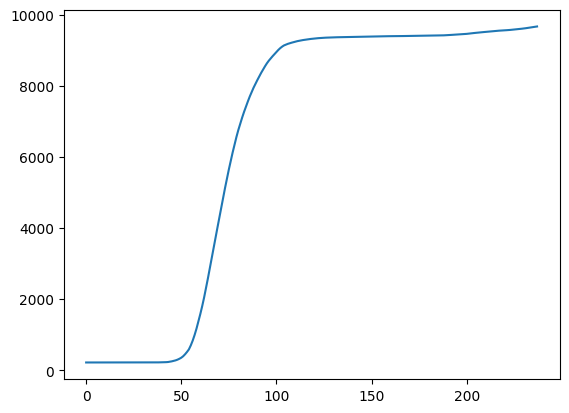

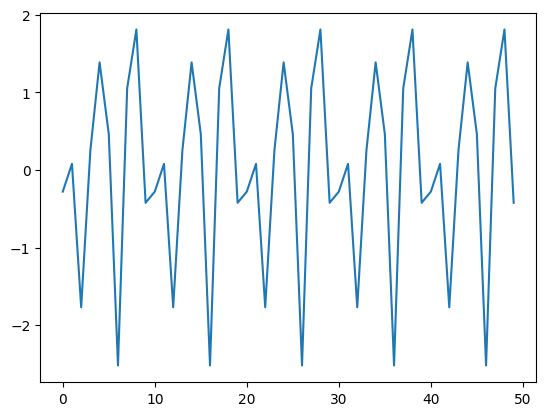

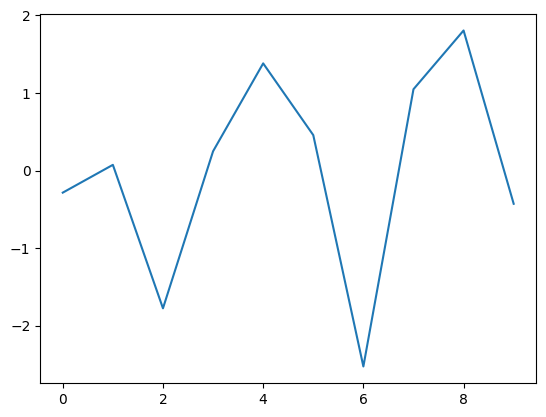

Hong Kong first wave decomposition 15 seasons


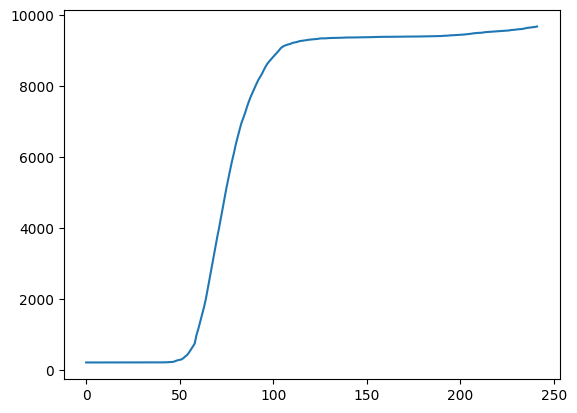

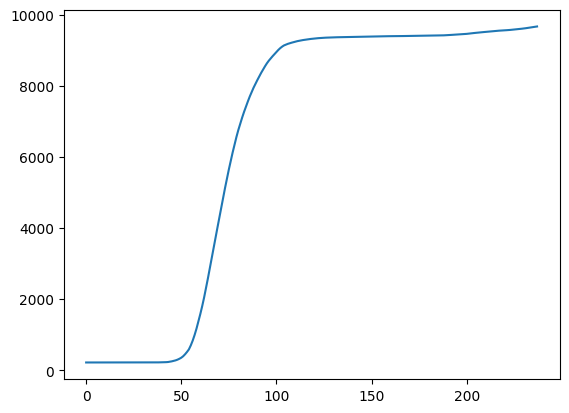

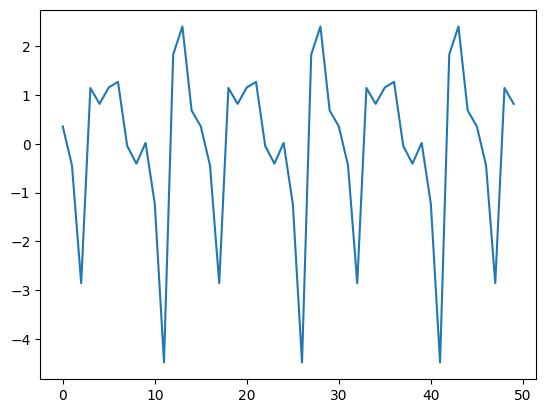

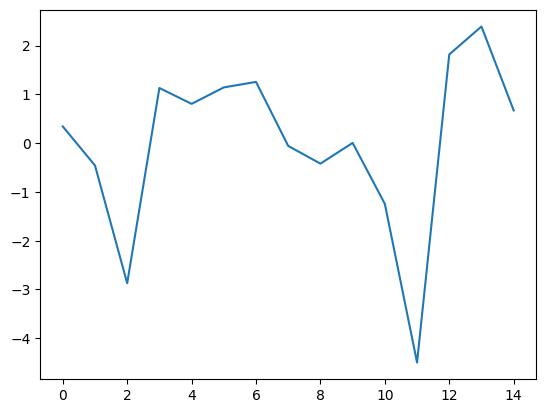

Hong Kong second wave decomposition 2 seasons


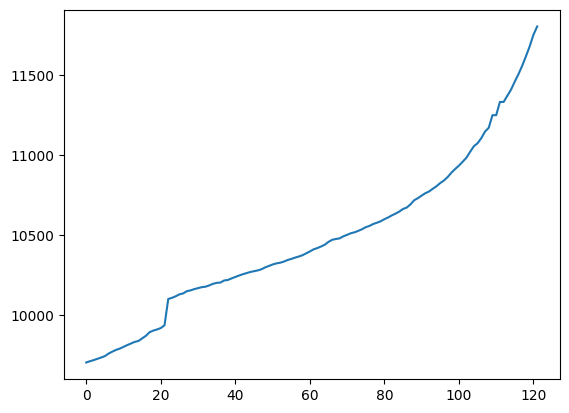

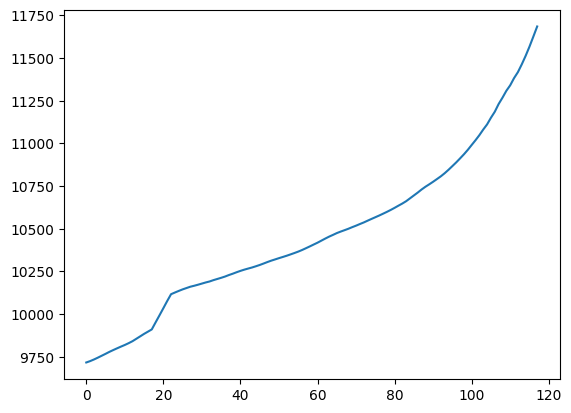

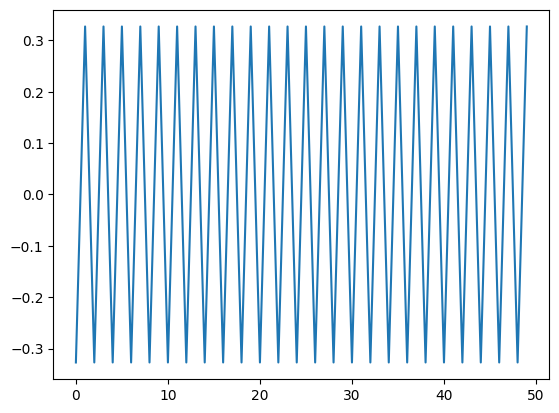

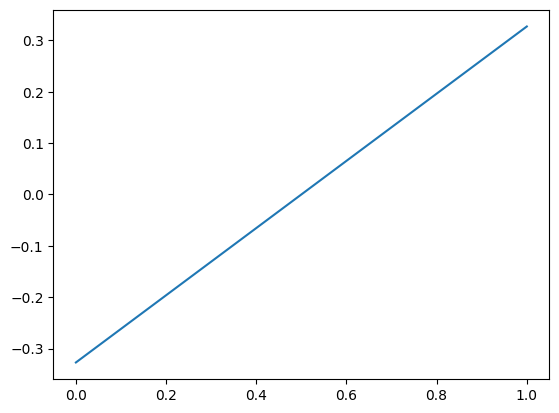

Hong Kong second wave decomposition 3 seasons


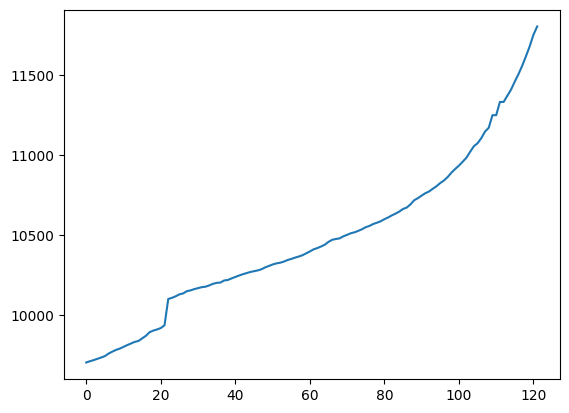

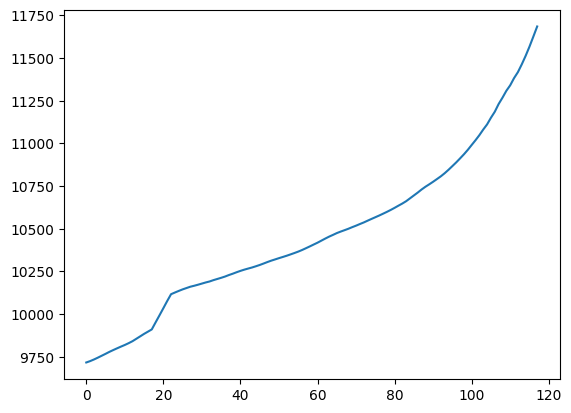

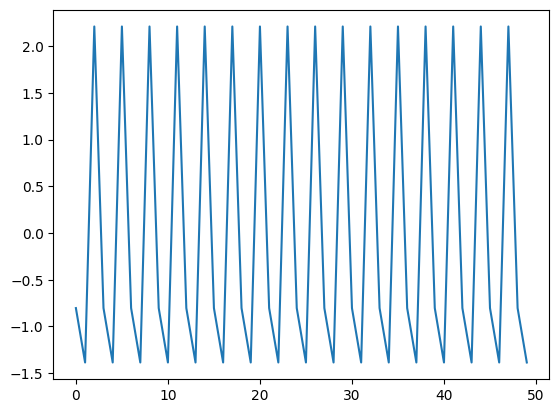

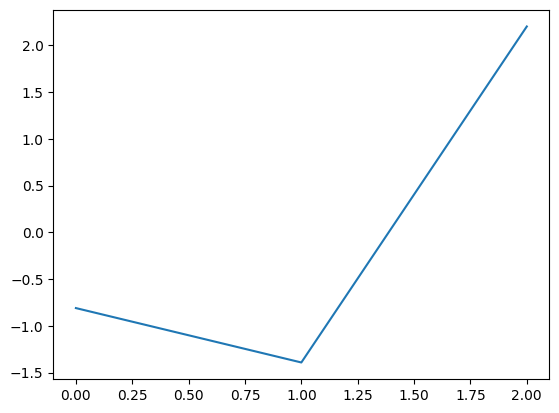

Hong Kong second wave decomposition 7 seasons


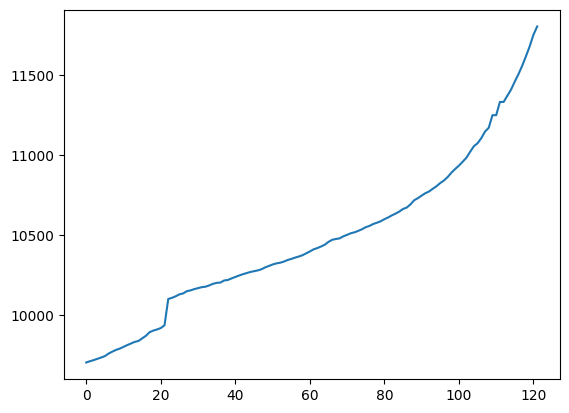

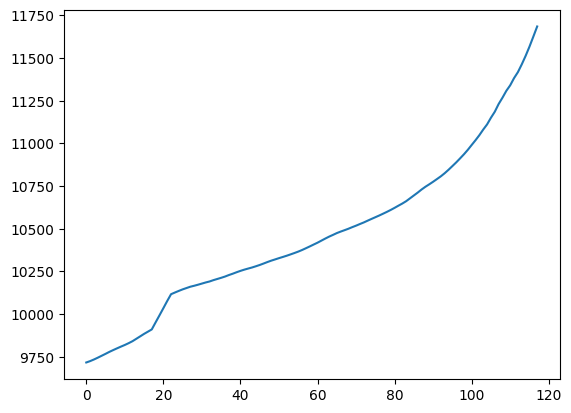

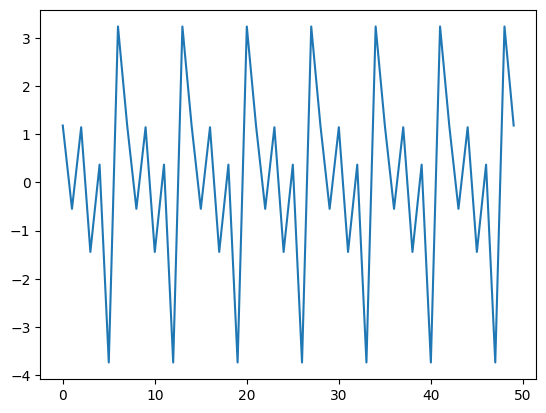

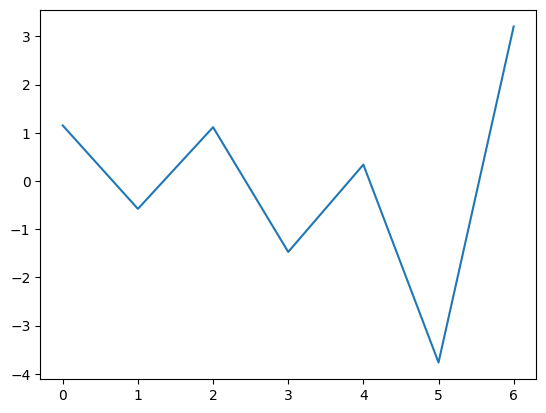

Hong Kong second wave decomposition 10 seasons


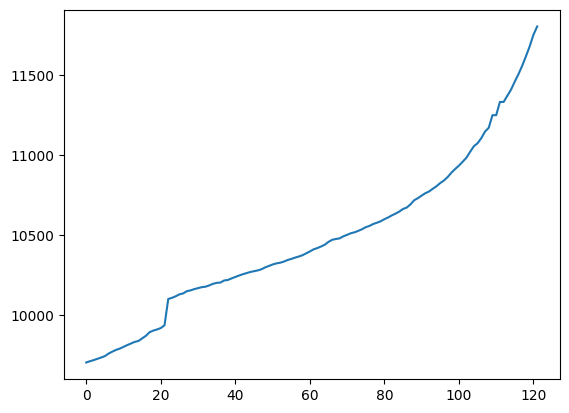

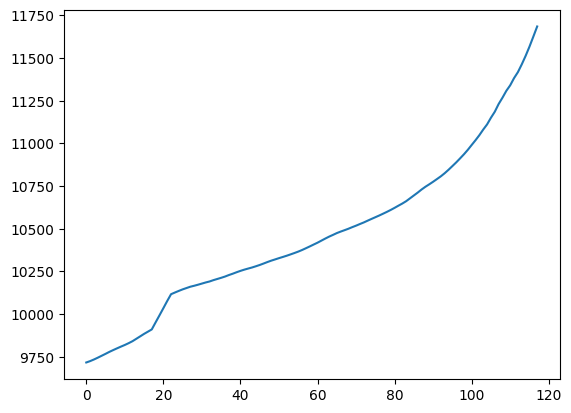

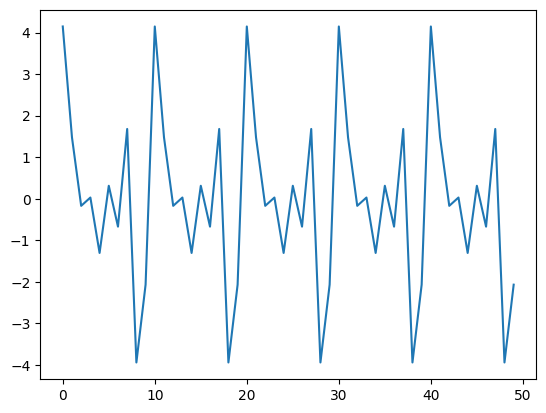

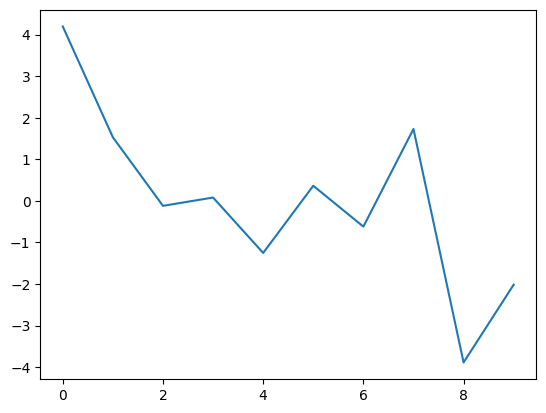

Hong Kong second wave decomposition 15 seasons


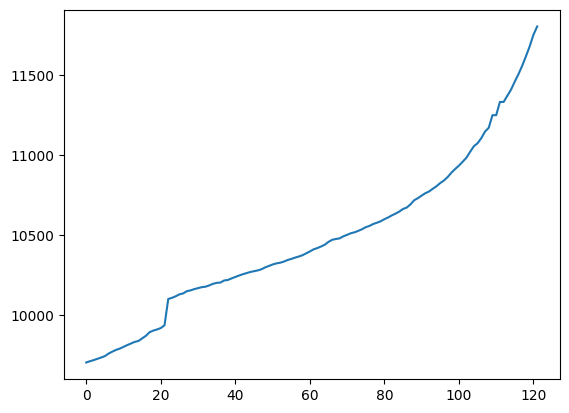

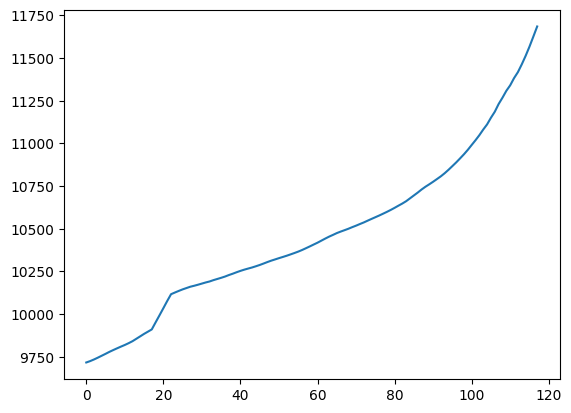

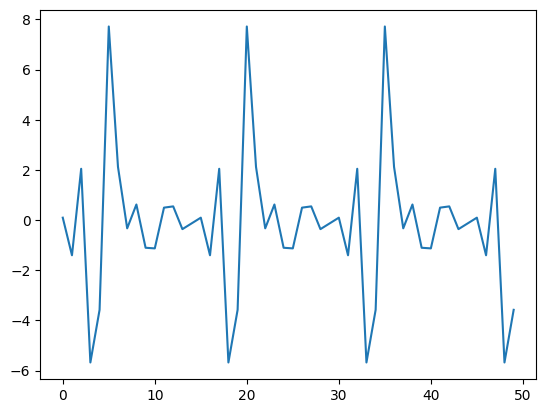

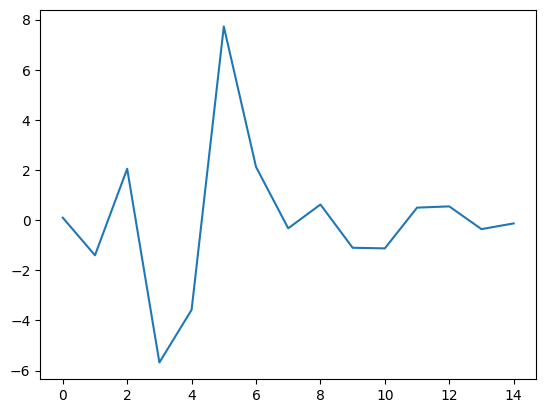

In [24]:
for i in range(N_GRAPHS):
    for seasons in (2, 3, 7, 10, 15):
        print(names[i] + " decomposition" + f" {seasons} seasons")
        plt.plot(series[i])
        plt.show()
        plt.plot(smas[i])
        plt.show()
        plt.plot(get_seasonal_full(series_no_m[i], seasons)[:50])
        plt.show()
        plt.plot(get_seasonal(series_no_m[i], seasons))
        plt.show()

Итого по первому пункту:

Бельгия 1: График почти гладкий и без сглаживания. Сезонность незначительная. Пока сложно что-то утверждать о сезонности, имеет смысл посмотреть на акф остатков при разных количествах сезонов.

Бельгия 2: Аналогично.

Гонг Конг 1: Аналогично.

Гонг Конг 2: Аналогично.

(Возможно, выбрал неудачные город и страну, но, как мне кажется, во всех других городах графики будут примерно аналогичные).

Ответ: В Бельгии может быть сезонность, В Гонг Конге сезонности нет (график гладкий).

Отметим, что у Бельгии для числа сезонов 7 больше всего амплитуда сезонности, что может говорить о наибольшей полезности именно этого числа сезонов в сравнении с другими.

Номер 2

In [16]:
datetime(2022, 1, 1).weekday(), datetime(2022, 9, 1).weekday()

(5, 3)

Для первой волны 0 - суббота,

для второй волны 0 - четверг

Belgium first wave seasonal 7 seasons


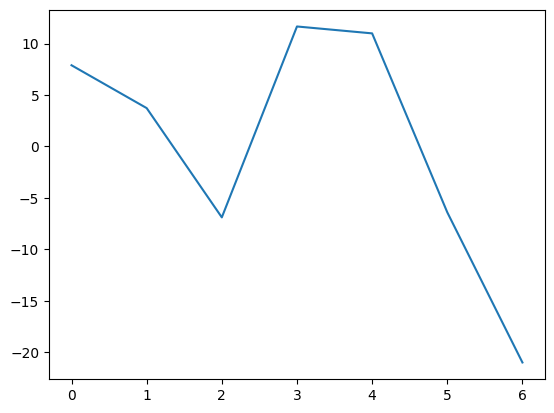

Belgium second wave seasonal 7 seasons


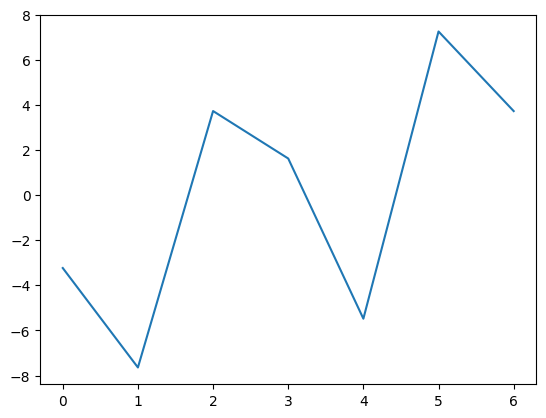

Hong Kong first wave seasonal 7 seasons


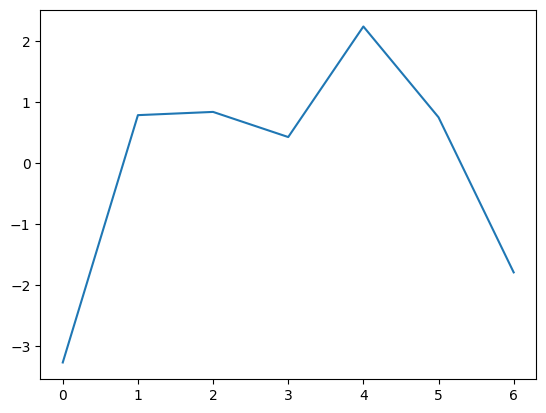

Hong Kong second wave seasonal 7 seasons


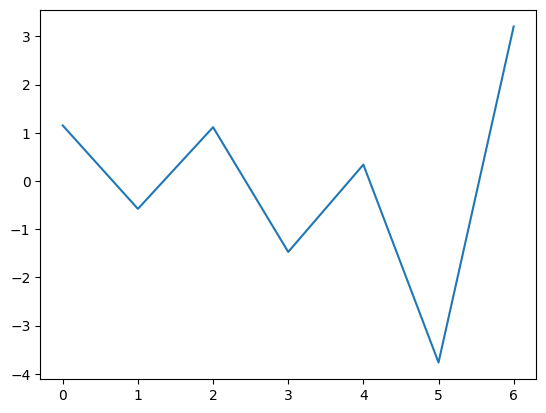

In [17]:
seasons = 7

for i in range(N_GRAPHS):
    s = get_seasonal(series_no_m[i], seasons)
    print(names[i] + " seasonal" + f" {seasons} seasons")
    plt.plot(s)
    plt.show()

Номер 3

Ответ:

Если полагаться на истинность показаний, то в среднем:

Бельгия 1: максимальна во вторник, минимальна в пятницу,

Бельгия 2: максимальна во вторник, минимальна в пятницу,

Гонг Конг 1: максимальна в среду, минимальна в субботу,

Гонг Конг 2: максимальна в среду, минимальна во вторник.

Результат сильно зависит от подхода к сглаживанию. Наиболее правдивое решение должно иметь стационарные остатки.

Номер 4

In [18]:
def get_hurst_exponent(time_series, max_lag=20):
#"""Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [19]:
nms = iter(names)
lags = [7, 30, 60, 90]
for ts in series:
    print(nms.__next__())
    persistent = np.zeros(len(lags))
    for i, lag in enumerate(lags):
        hurst_exp = get_hurst_exponent(ts, lag)
        persistent[i] = hurst_exp > 0.5
        print(f"Hurst exponent with {lag} lags: {hurst_exp:.4f}")
    if np.any(persistent == 1):
        print("Persistent")
    else:
        print("Not persistent")

Belgium first wave
Hurst exponent with 7 lags: 0.6439
Hurst exponent with 30 lags: 0.8554
Hurst exponent with 60 lags: 0.8520
Hurst exponent with 90 lags: 0.8160
Persistent
Belgium second wave
Hurst exponent with 7 lags: 0.3216
Hurst exponent with 30 lags: 0.3993
Hurst exponent with 60 lags: 0.2388
Hurst exponent with 90 lags: 0.0497
Not persistent
Hong Kong first wave
Hurst exponent with 7 lags: 0.9977
Hurst exponent with 30 lags: 0.9647
Hurst exponent with 60 lags: 0.8917
Hurst exponent with 90 lags: 0.8151
Persistent
Hong Kong second wave
Hurst exponent with 7 lags: 0.7475
Hurst exponent with 30 lags: 0.6585
Hurst exponent with 60 lags: 0.5129
Hurst exponent with 90 lags: 0.3616
Persistent


Поскольку Бельгия 2 - кусочно постоянный, Показатель Хёрста не дал хороший результат. Хотя из соответствующего графика видно, что зависимость есть, но средняя производная роста = $(33200 - 32500)/120 = 70/12 = 5$ смертей прирост в день, что мало относительно общего числа смертей.

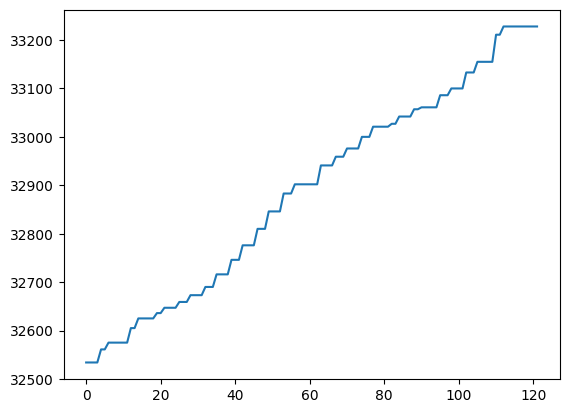

In [20]:
plt.plot(series[1])
plt.show()

Номер 5

In [27]:
seasons = (7, 7, 0, 0)
seasonal = list(map(lambda x: get_seasonal_full(series_no_m[x], seasons[x]), list(range(N_GRAPHS))))
resids = list(map(lambda x: series[x][SMA_LAGS-1:- SMA_LAGS + 1] - seasonal[x] - smas[x], list(range(N_GRAPHS))))

DF p-value 9.806780960559993e-08


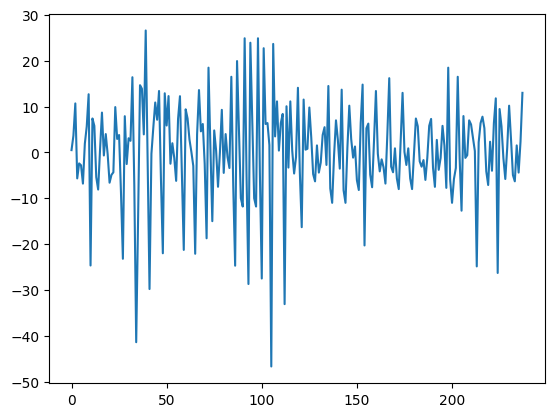

DF p-value 5.404121451149145e-09


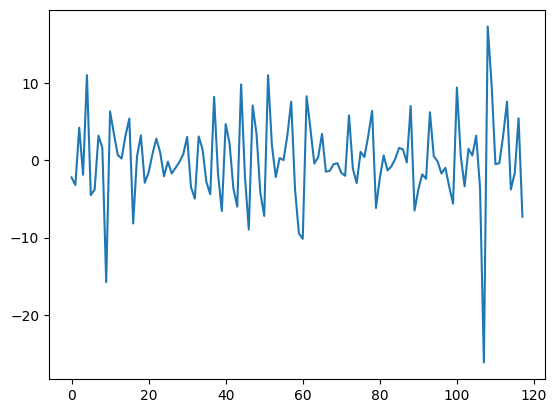

DF p-value 0.0033471179443310753


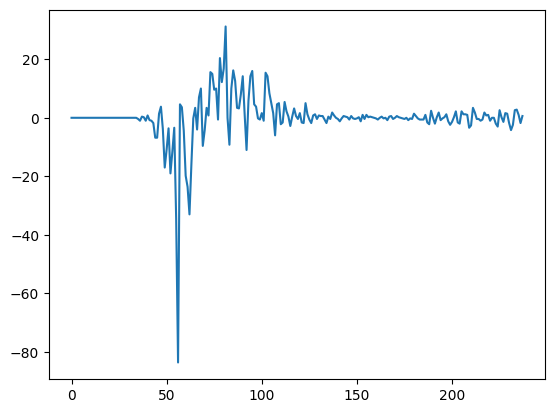

DF p-value 2.6010605248370973e-13


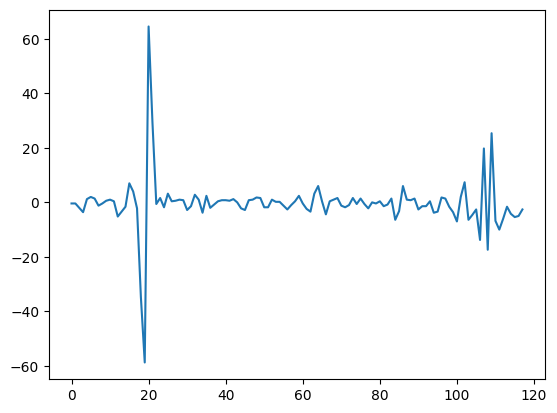

In [28]:
# Пусть альфа 0.05
for i in range(N_GRAPHS):
    print("DF p-value", adfuller(resids[i], autolag="AIC")[1])
    plt.plot(resids[i])
    plt.show()

Тест Дики-Фуллера говорит, что все ряды остатков стационарны.

Тест КПСС выдаёт ошибки, так что им не воспользовался.

Возможно, результат может вызвать сомнения, но в рамках данного решения будем считать, что критерий ДФ прав.

Номер 6

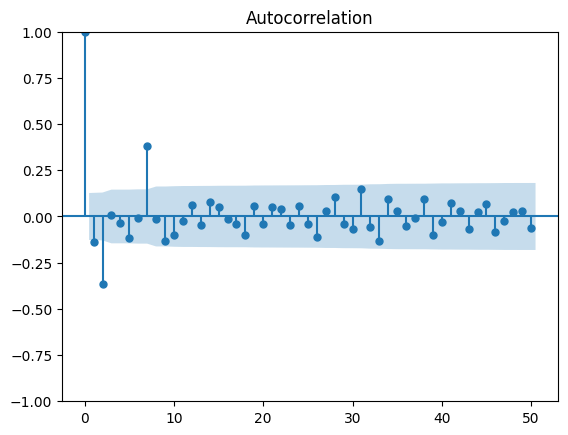

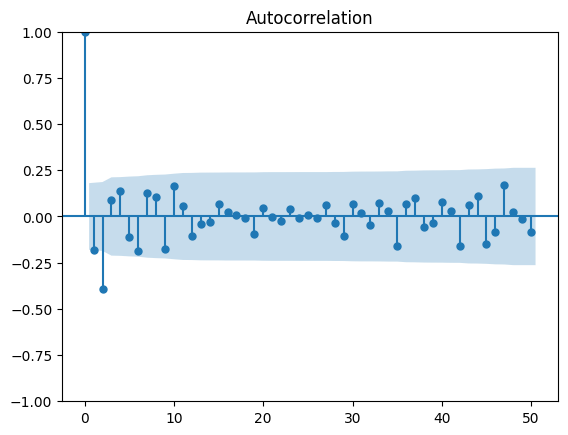

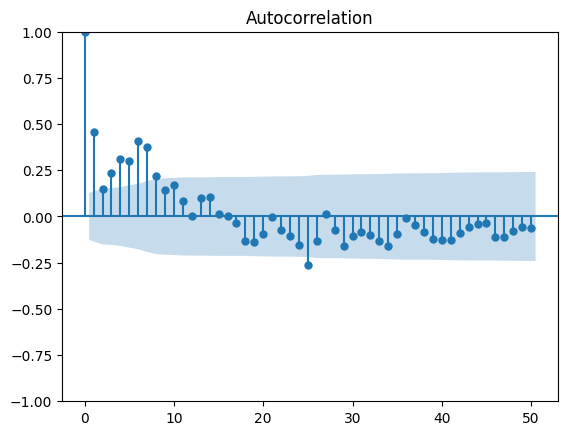

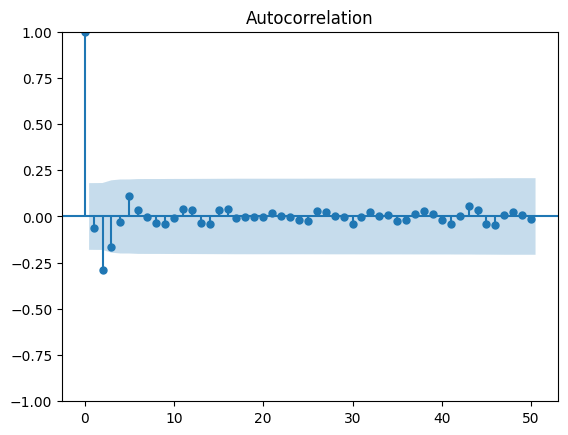

In [29]:
for i in range(N_GRAPHS):
    sm.graphics.tsa.plot_acf(resids[i], lags=50)
    plt.show()

Есть небольшие выходы за доверительный интервал, но не превосходящие 0.5. Будем считать, что всё хорошо.

Обратим внимание, что если брать другое число сезонов для Бельгии, то будут появляться периодичности в акф.